# Loading necessary libraries

In [1]:
%%capture
!pip install pandas_ta

In [2]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_ta as ta
import matplotlib.pyplot as plt

# Reading data

In [3]:
df=pd.read_csv("/kaggle/input/nifty-50-minute-data/NIFTY 50_minute.csv")
df

,date,open,high,low,close,volume
0,2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,0
1,2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,0
2,2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,0
3,2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,0
4,2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,0
...,...,...,...,...,...,...
898756,2024-09-27 15:25:00,26166.25,26168.40,26160.60,26161.95,0
898757,2024-09-27 15:26:00,26159.75,26169.80,26157.70,26169.80,0
898758,2024-09-27 15:27:00,26166.80,26184.55,26165.30,26183.40,0
898759,2024-09-27 15:28:00,26181.30,26188.35,26165.45,26179.35,0


In [4]:
df['timestamp'] = pd.to_datetime(df['date'])
df.set_index('timestamp', inplace=True) #Setting 'timestamp' as the index 

#Resample the data to daily frequency and aggregate OHLC
daily_ohlc = df.resample('D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})

daily_ohlc.dropna(inplace=True) #handiling missing data
#Print the daily OHLC data
print(daily_ohlc)

                open      high       low     close
timestamp                                         
2015-01-09   8285.45   8303.00   8191.10   8280.25
2015-01-12   8291.35   8332.25   8245.60   8326.55
2015-01-13   8346.15   8356.65   8268.15   8303.80
2015-01-14   8307.25   8326.30   8236.75   8287.75
2015-01-15   8425.20   8526.90   8380.75   8461.15
...              ...       ...       ...       ...
2024-09-23  25872.55  25956.00  25847.35  25930.15
2024-09-24  25921.45  26011.55  25886.85  25951.90
2024-09-25  25899.45  26032.80  25871.35  26013.50
2024-09-26  26005.40  26250.90  25998.40  26184.65
2024-09-27  26248.25  26277.35  26151.40  26175.00

[2407 rows x 4 columns]


In [5]:
df=pd.DataFrame(daily_ohlc)

# Adding Technical Indicators using Pandas_TA library

The Relative Strength Index (RSI) and Exponential Moving Average (EMA) are both technical indicators used in trading to help identify trends and make trading decisions: 

**RSI**
A popular indicator that measures the relative strength of buyers versus sellers. It's represented on a scale of 0–100, and values above 50 indicate more buying power, while values below 50 indicate more selling power. 

**EMA**
A moving average that responds more quickly to recent price changes. Short-term moving average crossovers, like the 5 EMA crossing over the 10 EMA, can be used to confirm RSI indications. 

When used together, the RSI and EMA can help improve trading performance. For example, a buy signal could be triggered when the 5 EMA crosses above the 12 EMA and the RSI crosses above 50. A sell signal could be triggered when the 5 EMA crosses below the 12 EMA and the RSI crosses below 50.

In [6]:
# Adding indicators
df['RSI']=ta.rsi(df.close, length=15)
df['EMAF']=ta.ema(df.close, length=20)
df['EMAM']=ta.ema(df.close, length=100)
df['EMAS']=ta.ema(df.close, length=150)

df['TargetNextClose'] = df['close'].shift(-1)

df.dropna(inplace=True)
df.reset_index(inplace = True)
df.drop(['timestamp'], axis=1, inplace=True)
df

,open,high,low,close,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,8530.50,8530.50,8428.55,8471.85,50.431066,8476.629767,8471.900245,8497.250333,8466.25
1,8503.75,8525.60,8433.60,8466.25,50.081337,8475.641218,8471.788359,8496.839733,8493.90
2,8468.05,8520.30,8426.55,8493.90,51.847859,8477.380149,8472.226213,8496.800796,8387.20
3,8477.15,8501.00,8359.75,8387.20,45.230030,8468.791564,8470.542526,8495.349130,8284.65
4,8298.70,8321.75,8225.25,8284.65,39.975723,8451.254272,8466.861486,8492.558413,7798.95
...,...,...,...,...,...,...,...,...,...
2252,25525.95,25849.25,25426.60,25820.35,72.093057,25193.612038,24099.264800,23516.845768,25930.15
2253,25872.55,25956.00,25847.35,25930.15,73.766460,25263.758511,24135.519953,23548.810062,25951.90
2254,25921.45,26011.55,25886.85,25951.90,74.096125,25329.295796,24171.487874,23580.639068,26013.50
2255,25899.45,26032.80,25871.35,26013.50,75.047634,25394.458101,24207.963362,23612.862392,26184.65


# Normalization

In [7]:
sc=MinMaxScaler(feature_range=(0,1))
data_set_scaled=sc.fit_transform(df)
print(data_set_scaled)

[[0.07938415 0.07792694 0.08356957 ... 0.05337852 0.04930021 0.07784388]
 [0.0779749  0.07767197 0.08383298 ... 0.0533718  0.04927444 0.07928292]
 [0.07609414 0.07739619 0.08346525 ... 0.05339808 0.049272   0.07372971]
 ...
 [0.99557733 0.98754553 0.99418163 ... 0.99546241 0.99584026 0.99109248]
 [0.99441832 0.98865126 0.99337317 ... 0.99765119 0.99786239 1.        ]
 [1.         1.         1.         ... 1.         1.         0.99949776]]


# LSTM Modeling

# Model 1: 30 days

In [8]:
X = []
backcandles = 30  
print(data_set_scaled.shape[0])
for j in range(8):  
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])
X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
print(X)
print(X.shape)
print(y)
print(y.shape)

2257
[[[0.07938415 0.07792694 0.08356957 ... 0.07123738 0.05337852 0.04930021]
  [0.0779749  0.07767197 0.08383298 ... 0.07118335 0.0533718  0.04927444]
  [0.07609414 0.07739619 0.08346525 ... 0.07127839 0.05339808 0.049272  ]
  ...
  [0.04277003 0.04483037 0.05100915 ... 0.03989825 0.03904021 0.0380585 ]
  [0.04578872 0.04474451 0.05021111 ... 0.03937364 0.03852866 0.03762989]
  [0.03698553 0.04649287 0.04511515 ... 0.03904084 0.03805962 0.03722962]]

 [[0.0779749  0.07767197 0.08383298 ... 0.07118335 0.0533718  0.04927444]
  [0.07609414 0.07739619 0.08346525 ... 0.07127839 0.05339808 0.049272  ]
  [0.07657355 0.07639192 0.07998101 ... 0.07080898 0.05329704 0.0491809 ]
  ...
  [0.04578872 0.04474451 0.05021111 ... 0.03937364 0.03852866 0.03762989]
  [0.03698553 0.04649287 0.04511515 ... 0.03904084 0.03805962 0.03722962]
  [0.04744557 0.04809033 0.05467595 ... 0.03935161 0.03773954 0.03693234]]

 [[0.07609414 0.07739619 0.08346525 ... 0.07127839 0.05339808 0.049272  ]
  [0.07657355 0.0

## Train-Test split

In [9]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1781
(1781, 30, 8)
(446, 30, 8)
(1781, 1)
(446, 1)
[[0.05082465]
 [0.06015634]
 [0.06130914]
 ...
 [0.60600549]
 [0.59970022]
 [0.59977569]]


## Model Building and Training

In [10]:
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=10, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0032 - val_loss: 7.4448e-04
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2.3937e-04 - val_loss: 2.5287e-04
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.5871e-04 - val_loss: 3.4580e-04
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.5581e-04 - val_loss: 6.3165e-04
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.4182e-04 - val_loss: 2.1253e-04
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.2866e-04 - val_loss: 2.7488e-04
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.3552e-04 - val_loss: 5.2796e-04
Epoch 8/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 2.0120e-04 - val_loss: 1.7816e-04
Epoch 9/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.2266e-04 - val_loss: 1.8317e-04
Epoch 10/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.2546e-04 - val_loss: 1.7909e-04
Epoch 11/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step

## Model Prediciton and Plotting results

In [11]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
[0.59866464] [0.60508689]
[0.5990201] [0.60749398]
[0.6060401] [0.594834]
[0.6091967] [0.58808635]
[0.5913584] [0.5962106]
[0.58610755] [0.59411058]
[0.5958913] [0.58483093]
[0.589604] [0.57999854]
[0.5811984] [0.56487423]
[0.5772746] [0.5745286]


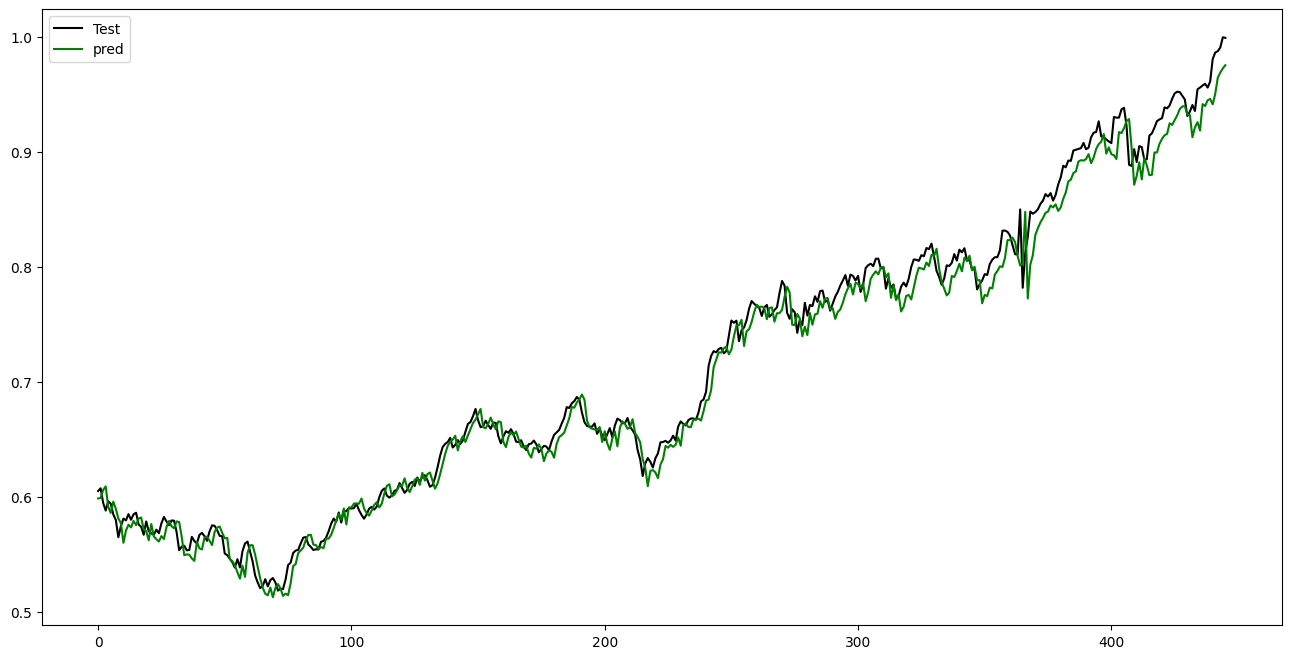

In [12]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

# Evaluation

In [13]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 0.00020149044271508228
RMSE: 0.014194732921583353
MAE: 0.011067973200580686
R-squared: 0.98745796945115


## Residuals

Residuals are the differences between the observed values (actual data) and the predicted values from your model. In mathematical terms:

Residual = Actual Stock Price - Predicted Stock Price

* A positive residual means your model underpredicted (predicted value is less than the actual value).
* A negative residual means your model overpredicted (predicted value is greater than the actual value).
* Ideally, residuals should be randomly scattered around zero.

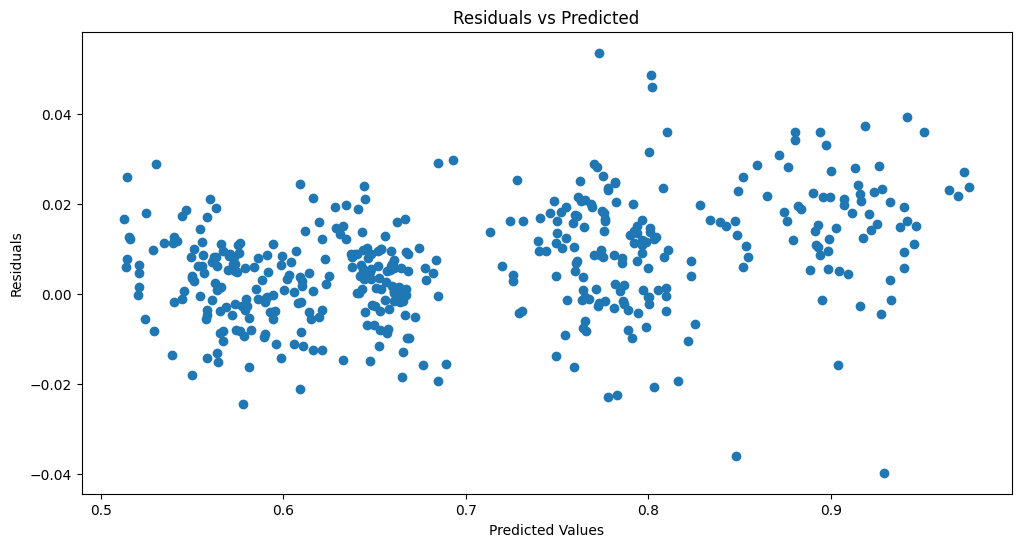

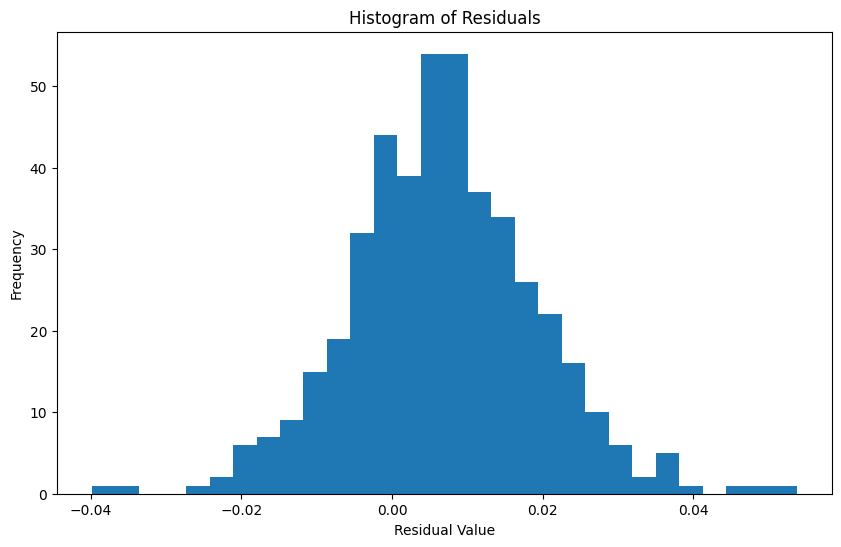

In [14]:
residuals = y_test.flatten() - y_pred.flatten()
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

#Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

## Directional Accuracy

In [15]:
def directional_accuracy(y_true, y_pred):
    return np.mean((y_true[1:] > y_true[:-1]) == (y_pred[1:] > y_pred[:-1]))

dir_acc = directional_accuracy(y_test, y_pred)
print(f"Directional Accuracy: {dir_acc}")

Directional Accuracy: 0.5280898876404494


## Sharpe Ratio

The Sharpe ratio measures risk-adjusted returns. A higher Sharpe ratio indicates better risk-adjusted performance.
* Sharpe ratios below 1 are considered sub-optimal
* 1-2 is considered okay
* 2-3 is very good
* Above 3 is excellent

Ratios below 1, indicate that the returns might not be compensating well for the risk taken.

In [16]:
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

predicted_returns = (y_pred[1:] - y_pred[:-1]) / y_pred[:-1]
actual_returns = (y_test[1:] - y_test[:-1]) / y_test[:-1]

# Calculate Sharpe ratios
sharpe_ratio_predicted = calculate_sharpe_ratio(predicted_returns)
sharpe_ratio_actual = calculate_sharpe_ratio(actual_returns)

print(f"Sharpe Ratio (Predicted): {sharpe_ratio_predicted}")
print(f"Sharpe Ratio (Actual): {sharpe_ratio_actual}")

Sharpe Ratio (Predicted): 0.09271758049726486
Sharpe Ratio (Actual): 0.10847788881025364


## Maximum Drawdown

Maximum Drawdown measures the largest peak-to-trough decline. A maximum drawdown of around 12-13% is not uncommon in stock markets, but it's significant enough to be concerning for risk-averse investors.

In [17]:
def calculate_max_drawdown(returns):
    prices = (1 + returns).cumprod()
    peak = np.maximum.accumulate(prices)
    drawdown = (prices - peak) / peak
    max_drawdown = np.min(drawdown)
    return max_drawdown

# Calculate returns
predicted_returns = (y_pred[1:] - y_pred[:-1]) / y_pred[:-1]
actual_returns = (y_test[1:] - y_test[:-1]) / y_test[:-1]

# Calculate Maximum Drawdown
mdd_predicted = calculate_max_drawdown(predicted_returns)
mdd_actual = calculate_max_drawdown(actual_returns)

print(f"Maximum Drawdown (Predicted): {mdd_predicted}")
print(f"Maximum Drawdown (Actual): {mdd_actual}")

Maximum Drawdown (Predicted): -0.15849106013774872
Maximum Drawdown (Actual): -0.14653307574673705


# Model 2: 60 days

## Code

2257
[[[0.07938415 0.07792694 0.08356957 ... 0.07123738 0.05337852 0.04930021]
  [0.0779749  0.07767197 0.08383298 ... 0.07118335 0.0533718  0.04927444]
  [0.07609414 0.07739619 0.08346525 ... 0.07127839 0.05339808 0.049272  ]
  ...
  [0.04498795 0.04432823 0.04938439 ... 0.04752683 0.03512209 0.03332991]
  [0.04002265 0.04238735 0.04811431 ... 0.04641233 0.03471932 0.03298576]
  [0.0389216  0.03861224 0.04722239 ... 0.0450521  0.03424419 0.03258997]]

 [[0.0779749  0.07767197 0.08383298 ... 0.07118335 0.0533718  0.04927444]
  [0.07609414 0.07739619 0.08346525 ... 0.07127839 0.05339808 0.049272  ]
  [0.07657355 0.07639192 0.07998101 ... 0.07080898 0.05329704 0.0491809 ]
  ...
  [0.04002265 0.04238735 0.04811431 ... 0.04641233 0.03471932 0.03298576]
  [0.0389216  0.03861224 0.04722239 ... 0.0450521  0.03424419 0.03258997]
  [0.03736747 0.04189042 0.04633047 ... 0.04406892 0.03383498 0.03223895]]

 [[0.07609414 0.07739619 0.08346525 ... 0.07127839 0.05339808 0.049272  ]
  [0.07657355 0.0

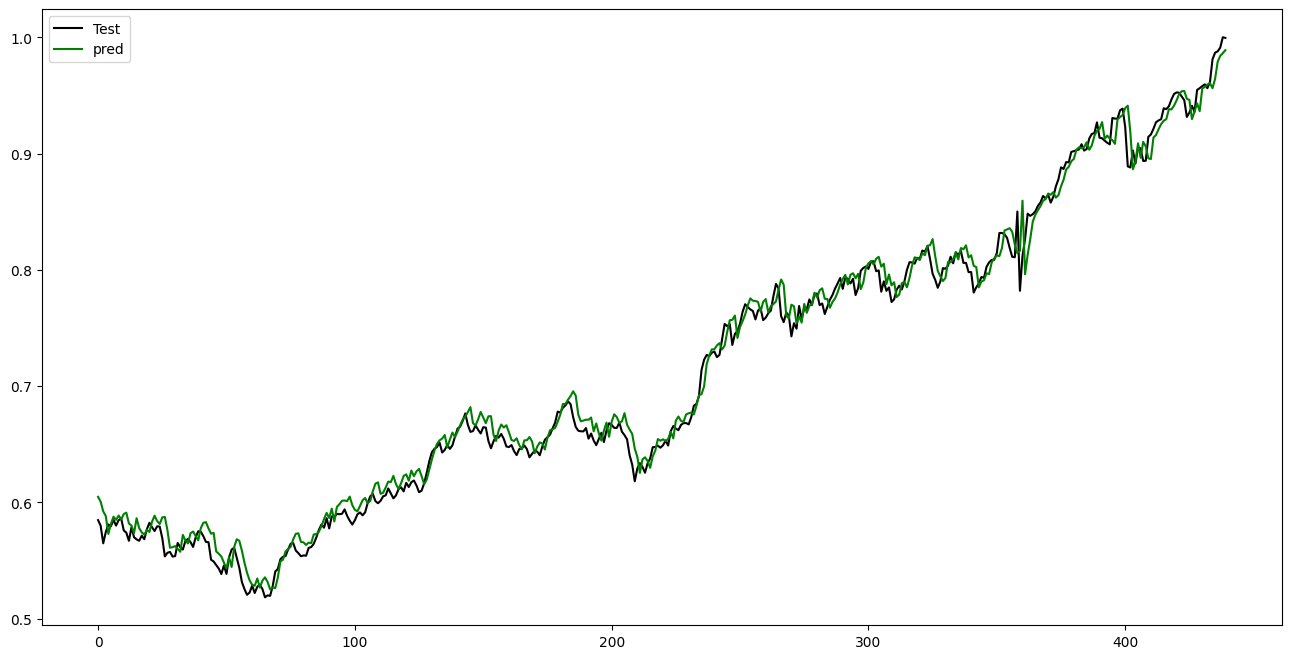

In [18]:
X = []
backcandles = 60  
print(data_set_scaled.shape[0])
for j in range(8):  
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])
X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
print(X)
print(X.shape)
print(y)
print(y.shape)
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=10, epochs=30, shuffle=True, validation_split = 0.1)
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

## Evaluation

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 0.0001440439588620052
RMSE: 0.012001831479487003
MAE: 0.009199066531947638
R-squared: 0.9910534705743963


## Residuals

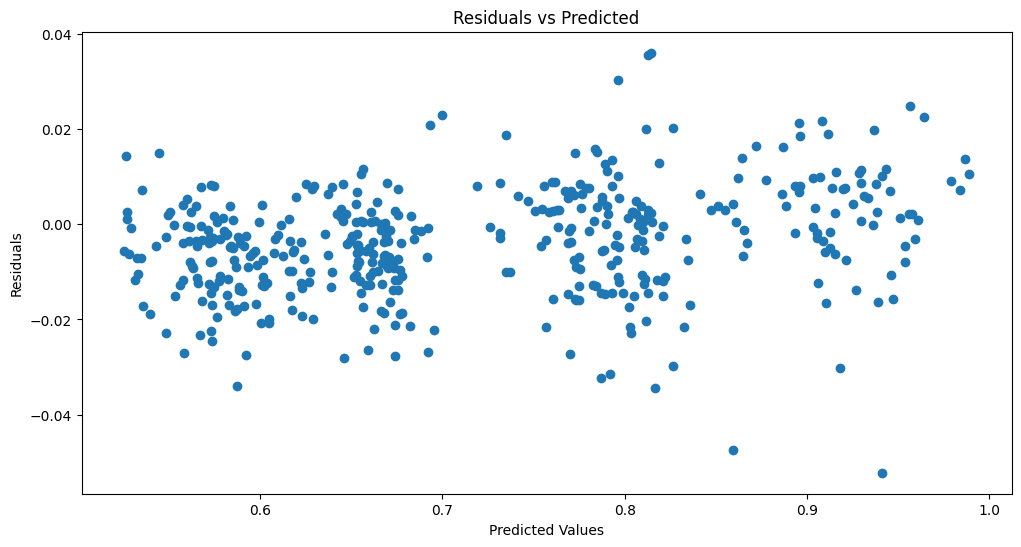

In [20]:
residuals = y_test.flatten() - y_pred.flatten()
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

This shows model is underpredicted

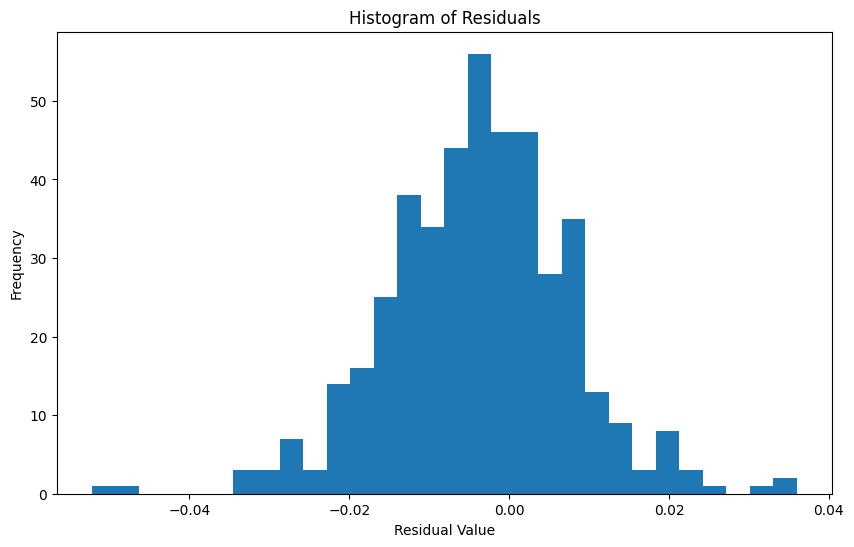

In [21]:
#Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

## Directional Accurcy

In [22]:
def directional_accuracy(y_true, y_pred):
    return np.mean((y_true[1:] > y_true[:-1]) == (y_pred[1:] > y_pred[:-1]))

dir_acc = directional_accuracy(y_test, y_pred)
print(f"Directional Accuracy: {dir_acc}")

Directional Accuracy: 0.530751708428246


## Sharpe Ratio

In [23]:
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

predicted_returns = (y_pred[1:] - y_pred[:-1]) / y_pred[:-1]
actual_returns = (y_test[1:] - y_test[:-1]) / y_test[:-1]

# Calculate Sharpe ratios
sharpe_ratio_predicted = calculate_sharpe_ratio(predicted_returns)
sharpe_ratio_actual = calculate_sharpe_ratio(actual_returns)

print(f"Sharpe Ratio (Predicted): {sharpe_ratio_predicted}")
print(f"Sharpe Ratio (Actual): {sharpe_ratio_actual}")

Sharpe Ratio (Predicted): 0.10669151693582535
Sharpe Ratio (Actual): 0.11737313682943636


## Maximum Drawdown

In [24]:
def calculate_max_drawdown(returns):
    prices = (1 + returns).cumprod()
    peak = np.maximum.accumulate(prices)
    drawdown = (prices - peak) / peak
    max_drawdown = np.min(drawdown)
    return max_drawdown

# Calculate returns
predicted_returns = (y_pred[1:] - y_pred[:-1]) / y_pred[:-1]
actual_returns = (y_test[1:] - y_test[:-1]) / y_test[:-1]

# Calculate Maximum Drawdown
mdd_predicted = calculate_max_drawdown(predicted_returns)
mdd_actual = calculate_max_drawdown(actual_returns)

print(f"Maximum Drawdown (Predicted): {mdd_predicted}")
print(f"Maximum Drawdown (Actual): {mdd_actual}")

Maximum Drawdown (Predicted): -0.1255016177892685
Maximum Drawdown (Actual): -0.11556542004217095


We can also compare them with any benchmark returns